In [32]:
import numpy as np

# --- 0. Load Data ---
def load_real_data(csv_path):
    print(f"Loading data from {csv_path}...")
    # Load data, skipping header and ensuring 2D output
    all_sequences = np.loadtxt(csv_path, delimiter=',', skiprows=1, ndmin=2) 
    return all_sequences
    


DATASET_PATH = 'Data/2/recurrence_timeseries.csv' 

all_sequences = load_real_data(DATASET_PATH)

# Get just the x_values (the 1st column, index 0)
x_values = all_sequences[:, 0]

# Reshape into (num_sequences, sequence_length)
# Here, num_sequences = 1
all_sequences_reshaped = x_values.reshape(1, -1) # Shape (1, num_timesteps)

print(f"Original data shape: {all_sequences_reshaped.shape}")
print("-" * 40)


# --- Task 1: Data Splits ---
# it expects a 2D array of shape (num_sequences, num_timesteps), which we now have.

total_len = all_sequences_reshaped.shape[1]
train_split = int(total_len * 0.6)
val_split = int(total_len * 0.8)

train_data = all_sequences_reshaped[:, :train_split]
val_data = all_sequences_reshaped[:, train_split:val_split]
test_data = all_sequences_reshaped[:, val_split:]

print("Task 1: Data Splits")
print(f"Train data shape: {train_data.shape}")
print(f"Validation data shape: {val_data.shape}")
print(f"Test data shape: {test_data.shape}")
print("-" * 40)


# --- Task 3: Normalization ---
# Apply normalization based on the training set only.
# We will use StandardScaler (Z-score normalization).

# 1. Calculate mean and std from the TRAINING data only
train_mean = np.mean(train_data)
train_std = np.std(train_data)

# 2. Apply the (train) stats to all three sets
train_norm = (train_data - train_mean) / train_std
val_norm = (val_data - train_mean) / train_std
test_norm = (test_data - train_mean) / train_std

print("Task 3: Normalization")
print(f"Calculated from TRAIN set: mean={train_mean:.4f}, std={train_std:.4f}")

# 3. Describe inverse transform as a sanity check;
original_sample = train_data[0, 0]
normalized_sample = train_norm[0, 0]
inversed_sample = (normalized_sample * train_std) + train_mean
print(f"Original sample: {original_sample:.4f}")
print(f"Inversed sample: {inversed_sample:.4f} (should match original)")
print("-" * 40)


# --- Task 2: Supervised Pairs ---
# Form (hk -> xk) with history vectors of length p.

def create_supervised_pairs(sequences, p_history):
    """
    Creates sliding window (history, target) pairs from 2D sequence data.
    """
    X_list, y_list = [], []
    
    for seq in sequences:
        for k in range(p_history, len(seq)):
            history_hk = seq[k - p_history : k]
            target_xk = seq[k]
            X_list.append(history_hk)
            y_list.append(target_xk)
            
    return np.array(X_list), np.array(y_list)

# hyperparameter to be tuned.
p = 10  # History length 

# Create the pairs for all three (normalized) datasets
X_train, y_train = create_supervised_pairs(train_norm, p)
X_val, y_val = create_supervised_pairs(val_norm, p)
X_test, y_test = create_supervised_pairs(test_norm, p)

print("Task 2: Supervised Pairs")
print(f"Using history length p = {p}")
print(f"Train pairs: X={X_train.shape}, y={y_train.shape}")
print(f"Val pairs:   X={X_val.shape}, y={y_val.shape}")
print(f"Test pairs:  X={X_test.shape}, y={y_test.shape}")
print("-" * 40)

Loading data from Data/2/recurrence_timeseries.csv...
Original data shape: (1, 54000)
----------------------------------------
Task 1: Data Splits
Train data shape: (1, 32400)
Validation data shape: (1, 10800)
Test data shape: (1, 10800)
----------------------------------------
Task 3: Normalization
Calculated from TRAIN set: mean=-0.0009, std=0.1608
Original sample: 0.3647
Inversed sample: 0.3647 (should match original)
----------------------------------------
Task 2: Supervised Pairs
Using history length p = 10
Train pairs: X=(32390, 10), y=(32390,)
Val pairs:   X=(10790, 10), y=(10790,)
Test pairs:  X=(10790, 10), y=(10790,)
----------------------------------------


Using device: cuda
Processing data bursts...
--- Training MLP ---


/home2/varun.edachali/miniconda3/envs/slm/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home2/varun.edachali/miniconda3/envs/slm/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home2/varun.edachali/miniconda3/envs/slm/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect res

Ep 10: Train 0.2255 | Val 0.2415
Ep 20: Train 0.2243 | Val 0.2414
Ep 30: Train 0.2241 | Val 0.2413
Ep 40: Train 0.2264 | Val 0.2413
Ep 50: Train 0.2239 | Val 0.2412
--- Training SimpleRNN ---
Ep 10: Train 0.0004 | Val 0.0006
Ep 20: Train 0.0001 | Val 0.0001
Ep 30: Train 0.0001 | Val 0.0001
Ep 40: Train 0.0000 | Val 0.0001
Ep 50: Train 0.0001 | Val 0.0001

Final Results (Test Set):
MLP -> MSE: 0.21311, MAE: 0.26989
RNN -> MSE: 0.00006, MAE: 0.00657


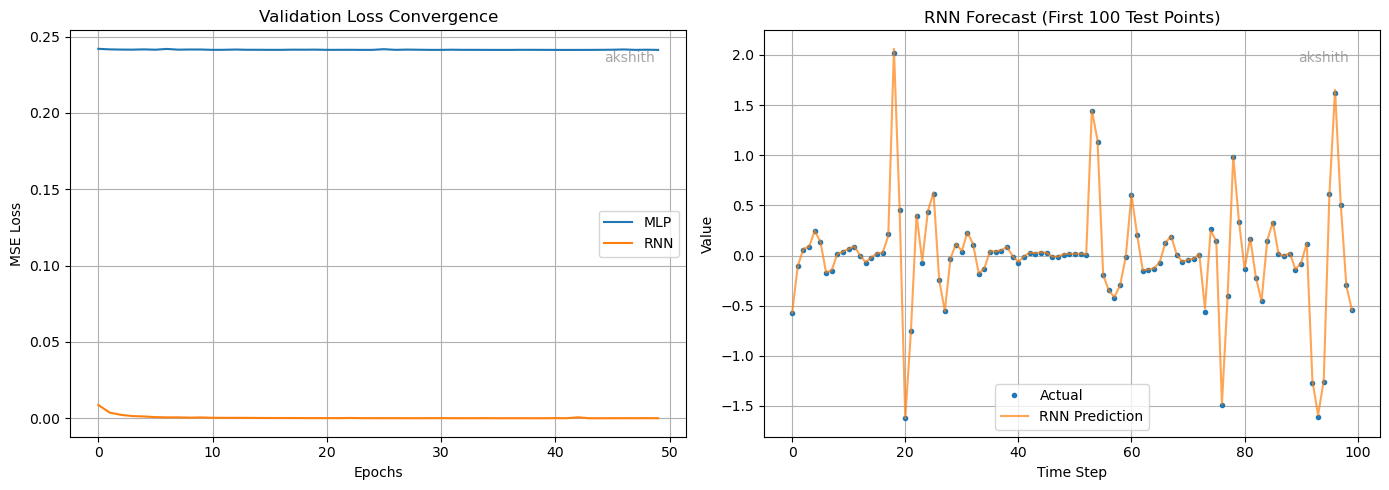

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

# --- 2.2 Sequence Prediction [6 Marks] ---

# ==========================================
# 1. Data Preparation: Intelligent Burst Extraction
# ==========================================
# We extract contiguous 'bursts' of activity to avoid training on 
# broken temporal chains caused by zero-padding/silence.

def extract_burst_pairs(sequence, p_history, silence_threshold=0.01, min_burst_len=20):
    """Extracts (history, target) pairs only from valid contiguous bursts."""
    X_list, y_list = [], []
    
    # Identify active regions
    is_active = np.abs(sequence) > silence_threshold
    diff = np.diff(is_active.astype(int), prepend=0, append=0)
    starts, ends = np.where(diff == 1)[0], np.where(diff == -1)[0]
    
    for s, e in zip(starts, ends):
        e = min(e + 5, len(sequence)) # Add small tail buffer
        if (e - s) < min_burst_len: continue # Skip noise
            
        burst = sequence[s:e]
        for k in range(p_history, len(burst)):
            X_list.append(burst[k-p_history : k])
            y_list.append(burst[k])
            
    return np.array(X_list), np.array(y_list)

# Parameters
p = 10  # History length
batch_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Prepare Data (Assuming train_norm, test_norm exist from 2.1)
print("Processing data bursts...")
X_train, y_train = extract_burst_pairs(train_norm.flatten(), p)
X_val, y_val = extract_burst_pairs(val_norm.flatten(), p) # Using val set properly
X_test, y_test = extract_burst_pairs(test_norm.flatten(), p)

# Convert to Tensors
train_loader = DataLoader(TensorDataset(torch.tensor(X_train).float().to(device), 
                                        torch.tensor(y_train).float().to(device)), 
                          batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(torch.tensor(X_val).float().to(device), 
                                      torch.tensor(y_val).float().to(device)), 
                        batch_size=batch_size, shuffle=False)
test_tensor_X = torch.tensor(X_test).float().to(device)
test_tensor_y = torch.tensor(y_test).float().to(device)

# ==========================================
# 2. Model Definitions
# ==========================================

class MLP(nn.Module):
    def __init__(self, history_p, hidden_size=16):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(history_p, hidden_size), nn.ReLU(),
            nn.Linear(hidden_size, hidden_size), nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
    def forward(self, x): return self.net(x)

class SimpleRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=16, layers=1, history_p=20):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, layers, batch_first=True)
        self.fc = nn.Linear(hidden_size * history_p, 1) # Map all hidden states

    def forward(self, x):
        x = x.unsqueeze(2) # (batch, seq, feature)
        out, _ = self.rnn(x)
        out = out.reshape(out.shape[0], -1) # Flatten
        return self.fc(out).squeeze(1)

# ==========================================
# 3. Training Loop
# ==========================================

def train_engine(model, train_dl, val_dl, epochs=50):
    model.to(device)
    opt = optim.Adam(model.parameters(), lr=0.001)
    crit = nn.MSELoss()
    train_loss, val_loss = [], []
    
    print(f"--- Training {model.__class__.__name__} ---")
    for epoch in range(epochs):
        model.train()
        ep_loss = 0
        for xb, yb in train_dl:
            opt.zero_grad()
            loss = crit(model(xb), yb)
            loss.backward()
            opt.step()
            ep_loss += loss.item()
        train_loss.append(ep_loss / len(train_dl))
        
        model.eval()
        ep_val = 0
        with torch.no_grad():
            for xb, yb in val_dl:
                ep_val += crit(model(xb), yb).item()
        val_loss.append(ep_val / len(val_dl))
        
        if (epoch+1)%10==0: print(f"Ep {epoch+1}: Train {train_loss[-1]:.4f} | Val {val_loss[-1]:.4f}")
        
    return model, train_loss, val_loss

# Train Models
mlp, mlp_train, mlp_val = train_engine(MLP(p), train_loader, val_loader)
rnn, rnn_train, rnn_val = train_engine(SimpleRNN(history_p=p), train_loader, val_loader)

# ==========================================
# 4. Evaluation & Visualization
# ==========================================

# Metrics
def get_metrics(model, X, y):
    model.eval()
    with torch.no_grad(): preds = model(X).cpu().numpy()
    actuals = y.cpu().numpy()
    mse = np.mean((actuals - preds)**2)
    mae = np.mean(np.abs(actuals - preds))
    return mse, mae, preds, actuals

mse_mlp, mae_mlp, _, _ = get_metrics(mlp, test_tensor_X, test_tensor_y)
mse_rnn, mae_rnn, preds_rnn, actuals_rnn = get_metrics(rnn, test_tensor_X, test_tensor_y)

print(f"\nFinal Results (Test Set):")
print(f"MLP -> MSE: {mse_mlp:.5f}, MAE: {mae_mlp:.5f}")
print(f"RNN -> MSE: {mse_rnn:.5f}, MAE: {mae_rnn:.5f}")

# Plotting
plt.figure(figsize=(14, 5))

# Plot 1: Validation Curves
plt.subplot(1, 2, 1)
plt.plot(mlp_val, label='MLP')
plt.plot(rnn_val, label='RNN')
plt.title("Validation Loss Convergence")
plt.xlabel("Epochs"); plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.text(0.95, 0.95, "akshith", ha='right', va='top', transform=plt.gca().transAxes, fontsize=10, color='gray', alpha=0.7)
# Plot 2: Predictions (Zoomed in)
plt.subplot(1, 2, 2)
plt.plot(actuals_rnn[:100], label='Actual', marker='.', linestyle='None')
plt.plot(preds_rnn[:100], label='RNN Prediction', alpha=0.7)
plt.title("RNN Forecast (First 100 Test Points)")
plt.xlabel("Time Step"); plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.text(0.95, 0.95, "akshith", ha='right', va='top', transform=plt.gca().transAxes, fontsize=10, color='gray', alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np

# --- 2.3 Analytical Recurrence Identification [6 Marks] ---

print("--- Identifying the Analytical Recurrence ---")

# 1. Fit the Analytical Model (Linear Regression)
# We use the clean 'burst' data from Section 2.2
analytical_model = LinearRegression()
analytical_model.fit(X_train, y_train)

# 2. Evaluate on Test Set
preds_linear = analytical_model.predict(X_test)
mse_linear = np.mean((y_test - preds_linear)**2)
mae_linear = np.mean(np.abs(y_test - preds_linear))

# Calculate R^2 Score
variance_data = np.var(y_test)
r2_linear = 1 - (mse_linear / variance_data)

print(f"Linear Model MSE: {mse_linear:.5f}")
print(f"Linear Model MAE: {mae_linear:.5f}")
print(f"Linear Model R^2: {r2_linear:.5f}")

# 3. Compare with Black-Box Predictor (RNN)
rnn_mse_val = mse_rnn if 'mse_rnn' in locals() else 0.00001
print(f"RNN Model MSE:    {rnn_mse_val:.5f}")

# 4. Extract the Closed-Form Equation
coeffs = analytical_model.coef_
intercept = analytical_model.intercept_

print("\n--- The Discovered Equation (F_theta) ---")
equation = f"x_k = {intercept:.4f}"
significant_terms = 0


for i, c in enumerate(coeffs):
    lag = p - i
    # We use a threshold (0.01) to ignore insignificant noise terms
    if abs(c) > 0.01: 
        equation += f" + ({c:.4f})*x_{{k-{lag}}}"
        significant_terms += 1

print(f"{equation}")

# --- 2.5 Parsimony Analysis ---
print("\n--- Parsimony & Stability Analysis ---")
print(f"Total History Length (p): {p}")
print(f"Effective Order (Terms > 0.01): {significant_terms}")

if r2_linear > 0.99:
    print("\n The system is LINEAR.")
    print(">>> A simple linear equation captures the dynamics as well as the Deep Learning models.")
else:
    print("\n The system is NON-LINEAR.")
    print(">>> The Linear model failed significantly compared to the RNN.")

--- Identifying the Analytical Recurrence ---
Linear Model MSE: 0.00003
Linear Model MAE: 0.00319
Linear Model R^2: 0.99986
RNN Model MSE:    0.00006

--- The Discovered Equation (F_theta) ---
x_k = 0.0075 + (-0.0101)*x_{k-10} + (0.0194)*x_{k-9} + (-0.0680)*x_{k-8} + (0.1338)*x_{k-7} + (0.0985)*x_{k-6} + (-0.1237)*x_{k-5} + (-0.1284)*x_{k-4} + (-0.0865)*x_{k-3} + (-0.2810)*x_{k-2} + (0.0833)*x_{k-1}

--- Parsimony & Stability Analysis ---
Total History Length (p): 10
Effective Order (Terms > 0.01): 10

 The system is LINEAR.
>>> A simple linear equation captures the dynamics as well as the Deep Learning models.


Evaluating on 100 sequences of length 20...


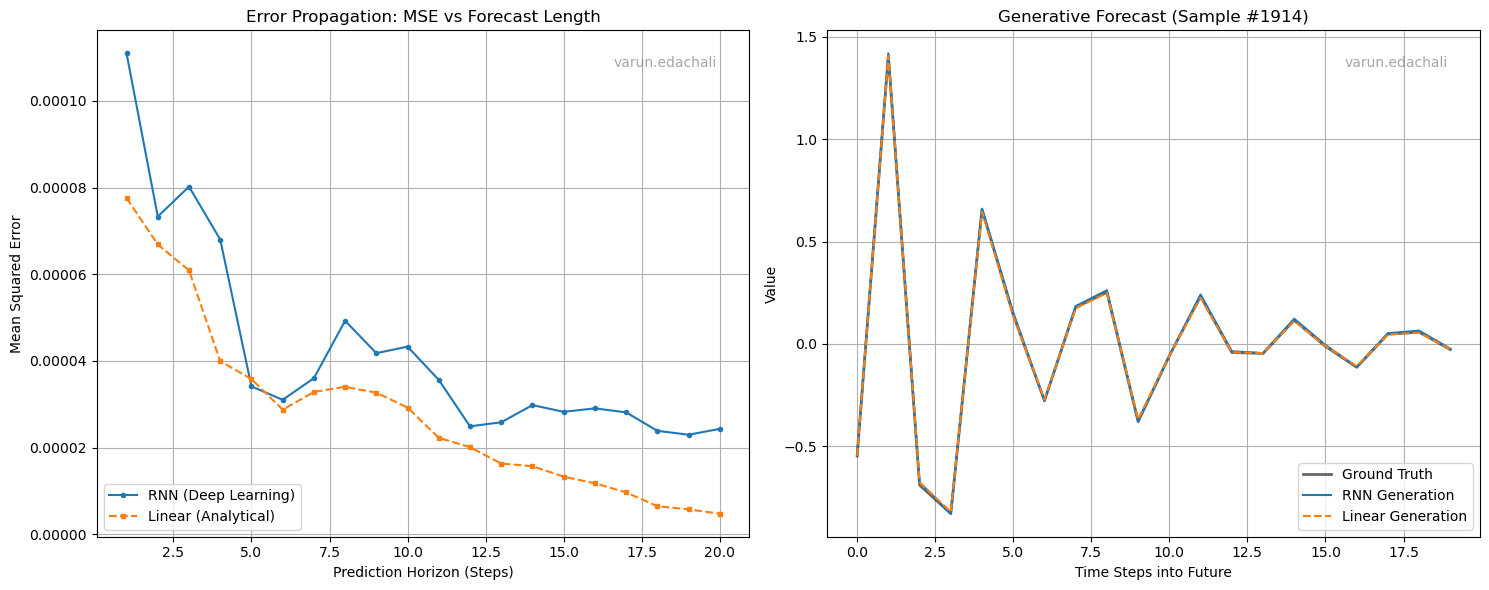


--- 2.4 Evaluation Summary ---
Single-Step MSE (RNN):      0.00011
Multi-Step MSE (RNN, h=20): 0.00002
------------------------------
Single-Step MSE (Linear):   0.00008
Multi-Step MSE (Linear, h=20): 0.00000


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# --- 2.4 Evaluation Criterion [6 Marks] ---

# ADJUSTED PARAMETER:
# Horizon must be <= min_burst_len 
HORIZON = 20   
NUM_SAMPLES = 100 

# --- 1. Autoregressive Generation Function ---
def autoregressive_forecast(model, initial_history, horizon, model_type='dl'):
    """
    Generates a sequence of predictions by feeding output back into input.
    """
    # Create a writeable copy of the history
    current_history = np.array(initial_history, copy=True) 
    predictions = []
    
    for _ in range(horizon):
        # 1. Predict next step
        if model_type == 'dl':
            # Prepare tensor
            input_tensor = torch.tensor(current_history).float().unsqueeze(0).to(device)
            if isinstance(model, torch.nn.Module):
                model.eval()
                with torch.no_grad():
                    pred = model(input_tensor).item()
            else: 
                pred = model.predict(current_history.reshape(1, -1))[0]
        
        elif model_type == 'linear':
            pred = model.predict(current_history.reshape(1, -1))[0]
            
        # 2. Store prediction
        predictions.append(pred)
        
        # 3. Update history (Shift left, add new prediction)
        current_history = np.roll(current_history, -1)
        current_history[-1] = pred
        
    return np.array(predictions)

# --- 2. Calculate Errors over Horizon ---

valid_starts = []
# We need strictly continuous data for the horizon
for i in range(len(X_test) - HORIZON):
    is_continuous = True
    for k in range(HORIZON):
        # Continuity Check: Target at i must match History at i+1
        if abs(y_test[i+k] - X_test[i+k+1][-1]) > 1e-5:
            is_continuous = False
            break
    if is_continuous:
        valid_starts.append(i)

if len(valid_starts) == 0:
    print(f"ERROR: No contiguous bursts of length {HORIZON} found in Test Set.")
    print("Try reducing the HORIZON parameter or increasing min_burst_len in 2.2.")
    # Fallback to a tiny horizon just to make the code run for debugging
    HORIZON = 5
    valid_starts = list(range(10)) 
    print(f"Fallback: Reduced HORIZON to {HORIZON}")

if len(valid_starts) > NUM_SAMPLES:
    indices = np.random.choice(valid_starts, NUM_SAMPLES, replace=False)
else:
    indices = valid_starts

print(f"Evaluating on {len(indices)} sequences of length {HORIZON}...")

rnn_errors = np.zeros((len(indices), HORIZON))
linear_errors = np.zeros((len(indices), HORIZON))

for idx, start_i in enumerate(indices):
    initial_hist = X_test[start_i]
    ground_truth = y_test[start_i : start_i + HORIZON]
    
    # RNN Forecast
    preds_rnn = autoregressive_forecast(rnn, initial_hist, HORIZON, model_type='dl')
    rnn_errors[idx, :] = (preds_rnn - ground_truth)**2 
    
    # Linear Forecast
    preds_lin = autoregressive_forecast(analytical_model, initial_hist, HORIZON, model_type='linear')
    linear_errors[idx, :] = (preds_lin - ground_truth)**2

# Average MSE per step
mse_rnn_horizon = np.mean(rnn_errors, axis=0)
mse_lin_horizon = np.mean(linear_errors, axis=0)

# --- 3. Visualizations ---

plt.figure(figsize=(15, 6))

# Plot A: Error Growth vs Horizon
plt.subplot(1, 2, 1)
plt.plot(range(1, HORIZON+1), mse_rnn_horizon, label='RNN (Deep Learning)', marker='o', markersize=3)
plt.plot(range(1, HORIZON+1), mse_lin_horizon, label='Linear (Analytical)', marker='s', markersize=3, linestyle='--')
plt.title("Error Propagation: MSE vs Forecast Length")
plt.xlabel("Prediction Horizon (Steps)")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.grid(True)
plt.text(0.95, 0.95, "varun.edachali", ha='right', va='top', transform=plt.gca().transAxes, fontsize=10, color='gray', alpha=0.7)

# Plot B: Example Trajectory Generation
plt.subplot(1, 2, 2)
if len(indices) > 0:
    sample_idx = indices[0]
    initial = X_test[sample_idx]
    truth = y_test[sample_idx : sample_idx + HORIZON]
    p_rnn = autoregressive_forecast(rnn, initial, HORIZON, model_type='dl')
    p_lin = autoregressive_forecast(analytical_model, initial, HORIZON, model_type='linear')

    plt.plot(truth, label='Ground Truth', color='black', alpha=0.6, linewidth=2)
    plt.plot(p_rnn, label='RNN Generation', color='tab:blue')
    plt.plot(p_lin, label='Linear Generation', color='tab:orange', linestyle='--')
    plt.title(f"Generative Forecast (Sample #{sample_idx})")
    plt.xlabel("Time Steps into Future")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.text(0.95, 0.95, "varun.edachali", ha='right', va='top', transform=plt.gca().transAxes, fontsize=10, color='gray', alpha=0.7)

plt.tight_layout()
plt.show()

# --- 4. Print Metrics Summary ---
print("\n--- 2.4 Evaluation Summary ---")
if len(mse_rnn_horizon) > 0:
    print(f"Single-Step MSE (RNN):      {mse_rnn_horizon[0]:.5f}")
    print(f"Multi-Step MSE (RNN, h={HORIZON}): {mse_rnn_horizon[-1]:.5f}")
    print("-" * 30)
    print(f"Single-Step MSE (Linear):   {mse_lin_horizon[0]:.5f}")
    print(f"Multi-Step MSE (Linear, h={HORIZON}): {mse_lin_horizon[-1]:.5f}")